In [1]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_stochastic, SEIR_stochastic, plot_samples

# Load and Prep Data

In [2]:
import jhu
import covidtracking
import states

# world data
world = jhu.load_world()

pop = {
    'Italy': 60.48e6,
    'US': 3.27e8,
}

data = {
    'Italy': world.Italy.tot,
    'US': world.US.tot
}

# US state data
US = covidtracking.load_us()
traits = states.uga_traits()

state_pop = { k: traits.totalpop[k] for k in traits.index }
state_data = { k: US[k] for k in US.columns.unique(level=0) }

# combine them
data = dict(data, **state_data)
pop = dict(pop, **state_pop)

# Run Inference

In [9]:
place = 'MA'

start = pd.Timestamp('2020-03-04')
confirmed = data[place].confirmed[start:]
start = confirmed.index.min()

T = len(confirmed)
N = pop[place]

args = {
    'N': N,
    'T': T,
    'drift_scale': 1e-1,
    'det_conc': 100,
}

"""
Specify initial parameters --- inference routines seem
unable to do this successfully on their own.

WARNING: DON'T INCLUDE EXTRA FIELDS IN DICTIONARY. This
seems to make inference fail without warning (it will
run but the sampler will diverge.)
"""

I_dur = 1.5
E_dur = 4.0
R0 = 3.5

SEIR = True

init = {
    'I0': 1000.,
    'gamma': 1 / I_dur,
    'beta0': R0 / I_dur,
    'beta': np.repeat(R0 / I_dur, T-1),
    'det_rate' : 0.3,
}


if SEIR:
    model = SEIR_stochastic
    init['E0'] = 1000.
    init['sigma'] = 1 / E_dur
else:
    model = SIR_stochastic
    
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1)

mcmc.run(jax.random.PRNGKey(2), 
         obs = confirmed.values,
         init_params = init,
         **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

# Posterior predictive samples for visualization
post_pred = Predictive(model, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

sample: 100%|██████████| 2000/2000 [01:31<00:00, 21.75it/s, 63 steps of size 4.63e-02. acc. prob=0.93]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0    109.38     61.62     97.66     17.10    198.53    491.35      1.00
        I0     15.78      6.08     14.45      7.31     23.80    622.68      1.00
   beta[0]      2.47      0.67      2.43      1.37      3.48    437.34      1.00
   beta[1]      2.43      0.63      2.37      1.38      3.32    505.03      1.00
   beta[2]      2.34      0.57      2.30      1.46      3.23    661.58      1.00
   beta[3]      2.19      0.50      2.15      1.40      2.97    770.79      1.00
   beta[4]      2.01      0.45      1.97      1.26      2.67    885.85      1.00
   beta[5]      1.83      0.40      1.80      1.21      2.43    945.94      1.00
   beta[6]      1.69      0.37      1.65      1.13      2.29    930.48      1.00
   beta[7]      1.59      0.36      1.55      0.98      2.13    912.37      1.00
   beta[8]      1.54      0.36      1.51      0.97      2.08    885.19      1.00
   beta[9]      1.53      0

# Inspect Results

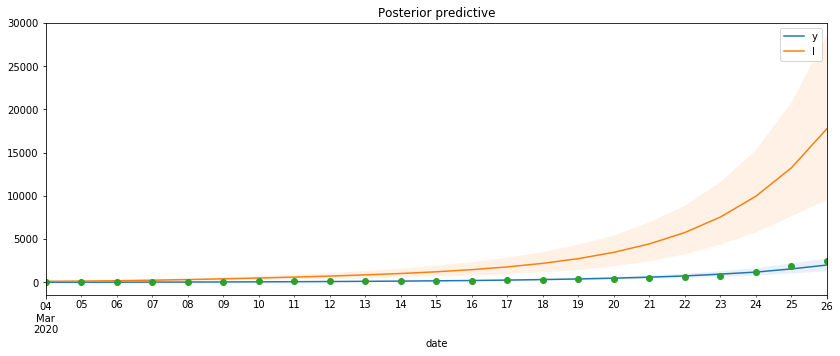

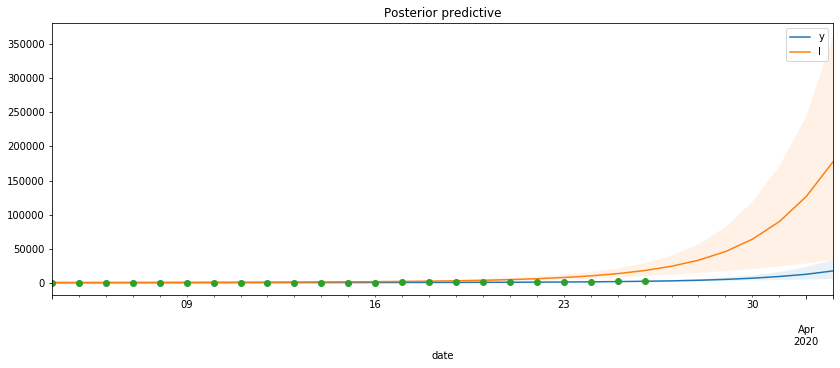

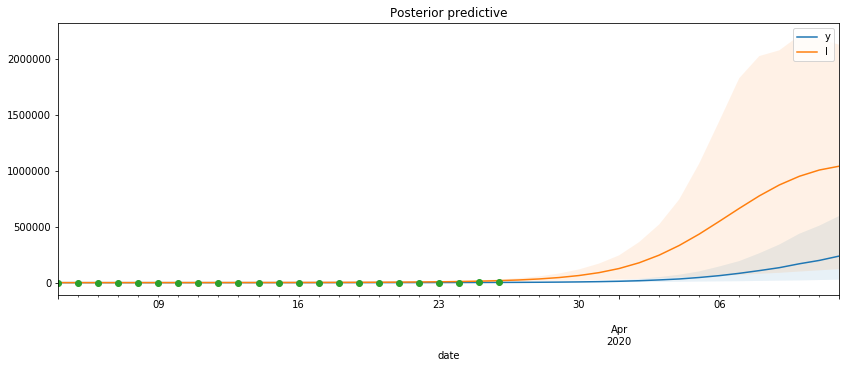

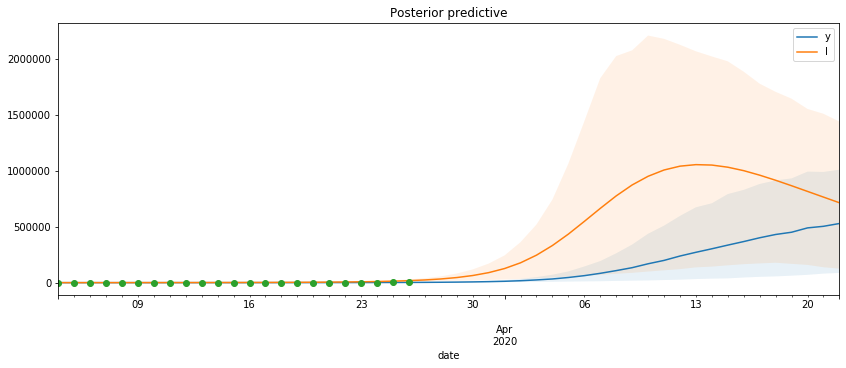

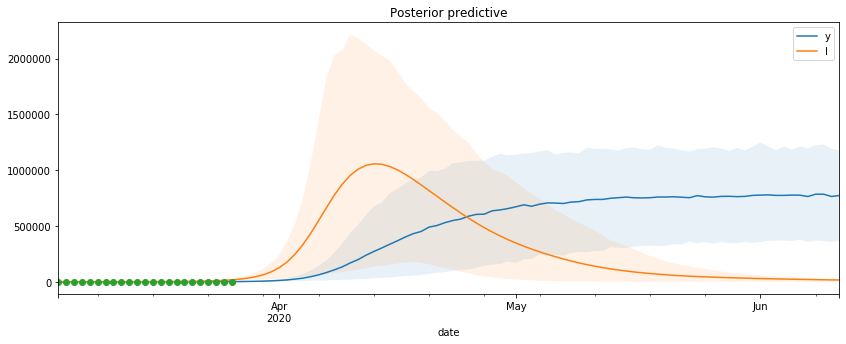

In [10]:
scale = 'lin'

for T in [len(confirmed), 30, 40, 50, 100]:
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    fig, ax = plt.subplots(figsize=(14,5))
    plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['y', 'I'])
    plt.title('Posterior predictive')
    
    confirmed.plot(style='o')
    
    if scale == 'log':
        plt.yscale('log')
        
    filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.pdf'
    plt.savefig(filename)
    plt.show()

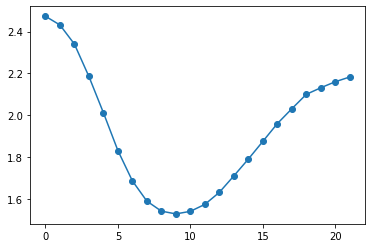

In [11]:
beta = mcmc_samples['beta']
plt.plot(beta.mean(axis=0), '-o')

In [ ]:
save = True

beta = mcmc_samples['beta0']
gamma = np.broadcast_to(mcmc_samples['gamma'], beta.shape)
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
plt.xlabel('beta - gamma')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [ ]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, obs_rate = SIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)    
    l2 = ax2.plot(ts, y, 'x', color='r')
        
    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=50, T_future=50, N=1e8)
        
    test_prior_predictive()